In [2]:
%pip install seaborn matplotlib pandas

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


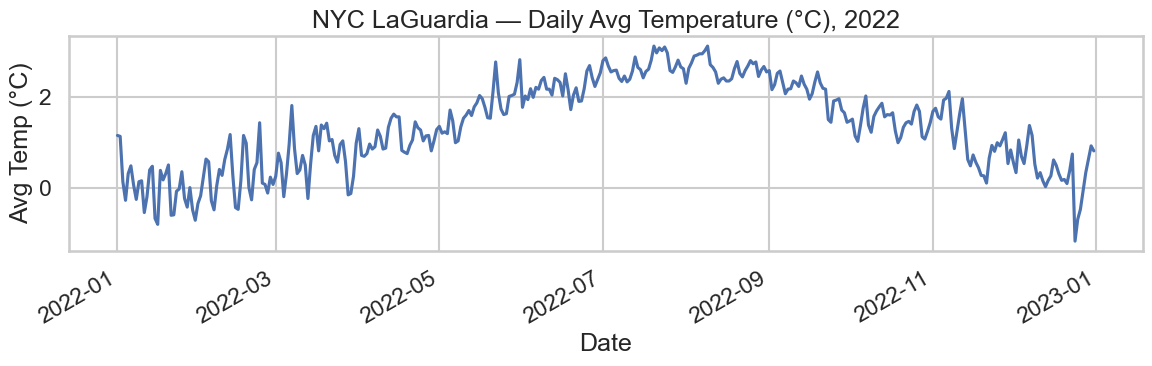

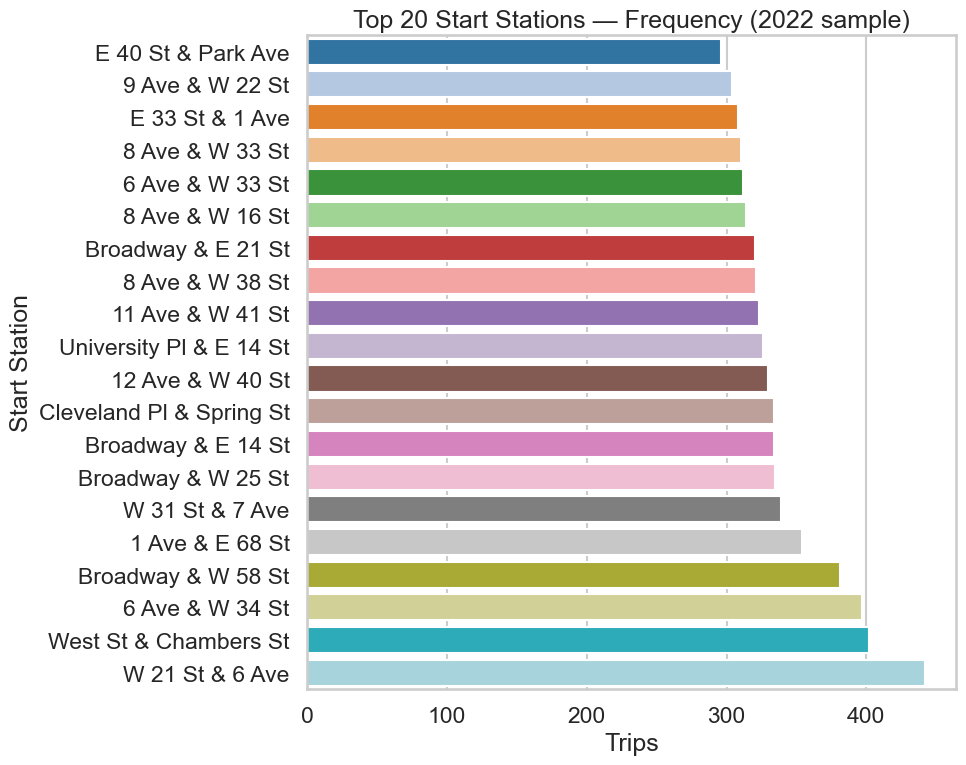

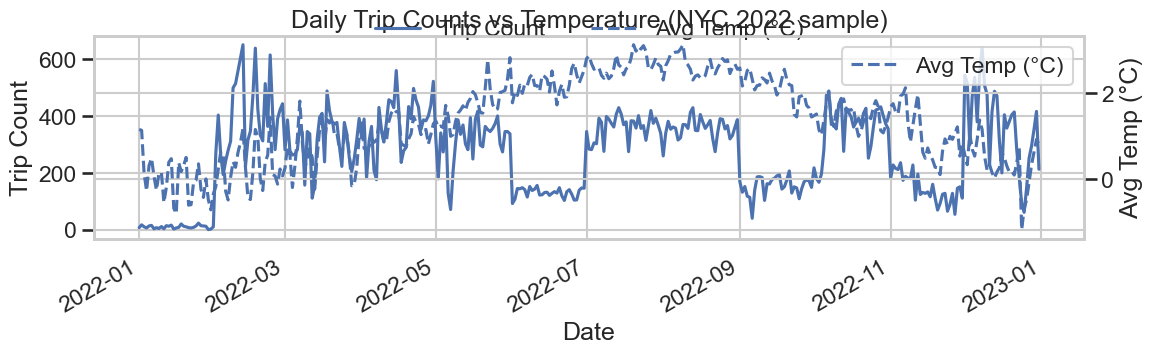

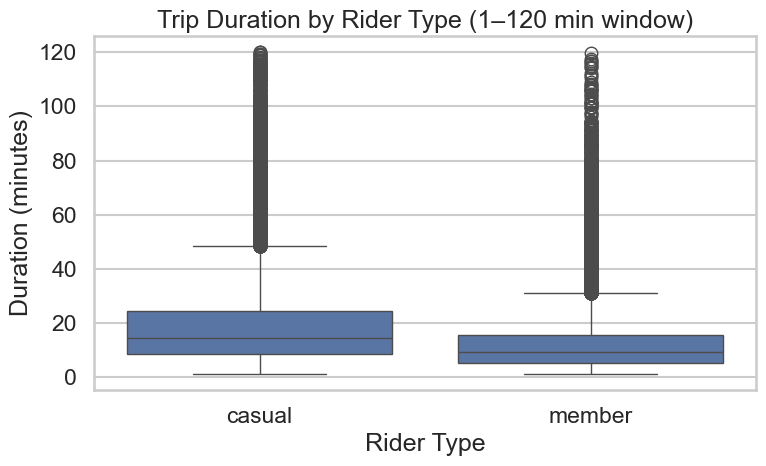

Duration summary (minutes) by rider type:
                  count       mean    median       25%        75%
member_casual                                                   
casual         21003.0  19.226995  14.17095  8.308942  24.322808
member         78191.0  12.200504   8.97725  5.234050  15.456933


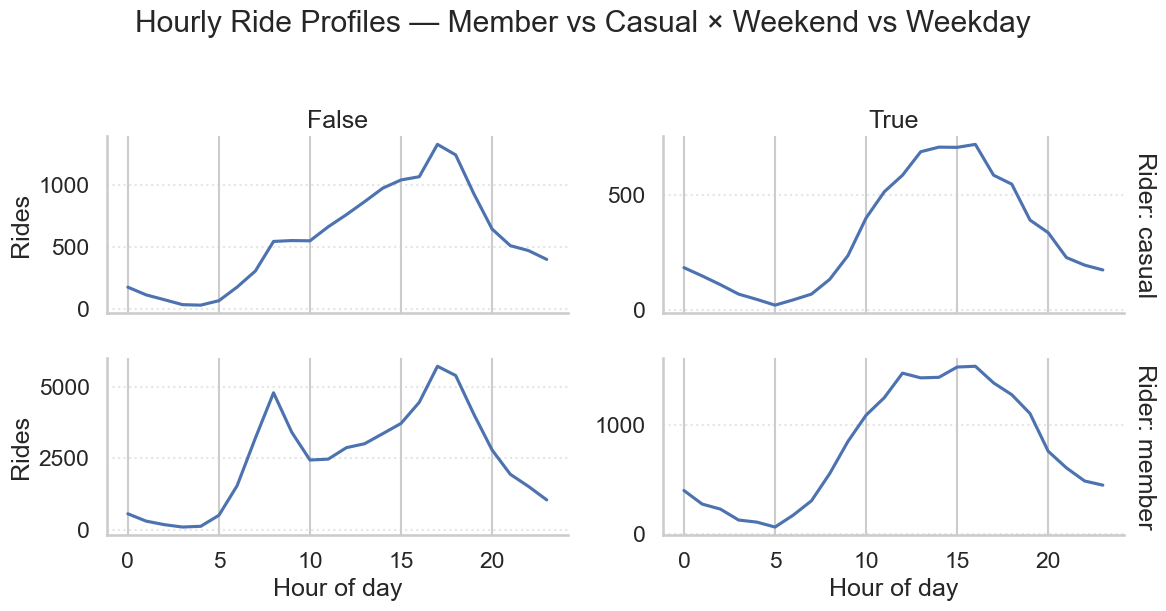


NOTE: Legend placed above to avoid overlap; groupby uses observed=True; Top-20 bar uses hue+tab20 so no seaborn palette warning.


In [5]:
# Exercise 2.4

# Imports (auto-install if running in Jupyter and seaborn/mpl missing)
import os
from pathlib import Path
import pandas as pd
import numpy as np
try:
    import seaborn as sns
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    %pip install seaborn matplotlib pandas
    import seaborn as sns
    import matplotlib.pyplot as plt

# Paths & data
CWD = Path.cwd().resolve()
PROJECT = CWD if (CWD / "Output").exists() else (CWD.parent if (CWD.parent / "Output").exists() else CWD)
OUT = PROJECT / "Output"

weather_csv = OUT / "laguardia_weather_2022.csv"
merged_sample = OUT / "citibike_weather_2022_sample_100k.csv"

assert weather_csv.exists(), f"Missing {weather_csv}"
assert merged_sample.exists(), f"Missing {merged_sample} — re-run 2.2 to create the 100k sample."

# Load & normalize dtypes
# Weather
dfw = pd.read_csv(weather_csv)
dfw["date"] = pd.to_datetime(dfw["date"], errors="coerce").dt.normalize()
dfw = dfw.sort_values("date", kind="mergesort").reset_index(drop=True)

# Trips sample
dft = pd.read_csv(merged_sample)

# Force datetime for started_at / ended_at (tz-aware UTC for safe subtraction)
for col in ["started_at", "ended_at"]:
    dft[col] = pd.to_datetime(dft[col], errors="coerce", utc=True)

# Build clean merge key: local tz-naive midnight date from started_at
dft["date"] = dft["started_at"].dt.tz_localize(None).dt.normalize()

# Categorical for tidy legends/Facets
if "member_casual" in dft.columns:
    dft["member_casual"] = dft["member_casual"].astype("category")

# Global seaborn theme
sns.set_theme(style="whitegrid", palette="deep", context="talk")

# (A) Temperature time series 
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=dfw, x="date", y="avgTemp", ax=ax)
ax.set_title("NYC LaGuardia — Daily Avg Temperature (°C), 2022")
ax.set_xlabel("Date"); ax.set_ylabel("Avg Temp (°C)")
fig.autofmt_xdate(); plt.tight_layout(); plt.show()

# (B) Top-20 start stations (override palette + hue; no warning)
if "start_station_name" in dft.columns:
    top20_df = (
        dft["start_station_name"]
        .dropna()
        .value_counts()
        .head(20)
        .rename_axis("start_station_name")
        .reset_index(name="trips")
        .sort_values("trips", ascending=True)
    )
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.barplot(
            data=top20_df,
            y="start_station_name",
            x="trips",
            hue="start_station_name",                      # distinct color per bar
            dodge=False,
            legend=False,                                  # avoid giant legend
            palette=sns.color_palette("tab20", n_colors=len(top20_df))
        )
        ax.set_title("Top 20 Start Stations — Frequency (2022 sample)")
        ax.set_xlabel("Trips"); ax.set_ylabel("Start Station")
        plt.tight_layout(); plt.show()
else:
    print("Column 'start_station_name' not in sample; skipping Top-20 bar chart.")

# (C) Daily trips + merge with weather (dtype-safe)
daily_trips = (
    dft.groupby("date", as_index=False, observed=True)
       .size()
       .rename(columns={"size": "trip_count"})
)
# Ensure both are datetime64[ns] normalized
daily_trips["date"] = pd.to_datetime(daily_trips["date"], errors="coerce").dt.normalize()
dfw["date"] = pd.to_datetime(dfw["date"], errors="coerce").dt.normalize()

df_daily = dfw.merge(daily_trips, on="date", how="left")
df_daily["trip_count"] = df_daily["trip_count"].fillna(0).astype("int64")

#(D) Dual-axis (trips vs temp) with legend above (no overlap) 
fig, ax1 = plt.subplots(figsize=(12, 4))
sns.lineplot(data=df_daily, x="date", y="trip_count", ax=ax1, label="Trip Count")
ax1.set_xlabel("Date"); ax1.set_ylabel("Trip Count")

ax2 = ax1.twinx()
sns.lineplot(data=df_daily, x="date", y="avgTemp", ax=ax2, label="Avg Temp (°C)", linestyle="--")
ax2.set_ylabel("Avg Temp (°C)")

# Combine legends and place above plot
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper center", bbox_to_anchor=(0.5, 1.18), ncol=2, frameon=False)

ax1.set_title("Daily Trip Counts vs Temperature (NYC 2022 sample)")
fig.autofmt_xdate(); plt.tight_layout(); plt.show()

# (E) Box plot: trip duration by rider type (with clean summary)
dft_valid = dft.dropna(subset=["started_at", "ended_at", "member_casual"]).copy()
dft_valid["duration_min"] = (dft_valid["ended_at"] - dft_valid["started_at"]).dt.total_seconds() / 60.0

# Keep a readable window
dft_box = dft_valid.loc[(dft_valid["duration_min"] > 1) & (dft_valid["duration_min"] <= 120)].copy()

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=dft_box, x="member_casual", y="duration_min", ax=ax)
ax.set_title("Trip Duration by Rider Type (1–120 min window)")
ax.set_xlabel("Rider Type"); ax.set_ylabel("Duration (minutes)")
plt.tight_layout(); plt.show()

# Summary with 'median' column 
summary = (
    dft_box.groupby("member_casual", observed=True)["duration_min"]
           .describe(percentiles=[0.25, 0.5, 0.75])
           .rename(columns={"50%": "median"})
           [["count", "mean", "median", "25%", "75%"]]
)
print("Duration summary (minutes) by rider type:\n", summary.to_string())

# (F) FacetGrid: hourly profiles by rider type × weekend
dft["hour"] = dft["started_at"].dt.hour
dft["is_weekend"] = dft["started_at"].dt.weekday >= 5
profiles = (
    dft.groupby(["member_casual", "is_weekend", "hour"], as_index=False, observed=True)
      .size()
      .rename(columns={"size": "rides"})
)

g = sns.FacetGrid(
    profiles,
    row="member_casual",
    col="is_weekend",
    margin_titles=True,
    sharey=False,
    height=3,
    aspect=2
)
g.map_dataframe(sns.lineplot, x="hour", y="rides")
g.set_axis_labels("Hour of day", "Rides")
g.set_titles(row_template="Rider: {row_name}", col_template="{col_name}")
for ax in g.axes.flat:
    ax.grid(True, axis="y", linestyle=":", alpha=0.5)
plt.suptitle("Hourly Ride Profiles — Member vs Casual × Weekend vs Weekday", y=1.03)
plt.tight_layout(); plt.show()

print("\nNOTE: Legend placed above to avoid overlap; groupby uses observed=True; Top-20 bar uses hue+tab20 so no seaborn palette warning.")


## Exercise 2.4 — Notes & Interpretation

**Theme**  
I set a global Seaborn theme with `sns.set_theme(style="whitegrid", palette="deep", context="talk")`.  
This keeps typography and gridlines consistent across plots and gives a readable default palette.

**Top-20 Start Stations**  
The global palette doesn’t have 20 distinct hues, so for this *one* chart I overrode the palette and added a `hue` per station: `palette=sns.color_palette("tab20", n_colors=20)`, `hue="start_station_name"`, `legend=False`. This avoids Seaborn’s “palette without hue” warning and ensures clear bar colors while keeping the overall white-grid style.

**Dual-axis Trips vs Temperature**  
I used Seaborn `lineplot` on two y-axes: `ax1` for `trip_count` (left) and `ax2 = ax1.twinx()` for `avgTemp` (right). I combined legends with `ax1.get_legend_handles_labels()` + `ax2.get_legend_handles_labels()` and placed them **above** the axes (`bbox_to_anchor`) so they don’t overlap the plot. A dual axis is justified here because the series are in different units (counts vs °C), and the shared date axis preserves temporal alignment.

**Box Plot**  
Trip duration (minutes) is computed as `(ended_at - started_at)` and limited to a 1–120 minute window for readability. The box plot shows **median** (line), **IQR** (box), and **outliers** (points beyond whiskers). In the sample, casual riders typically have a higher median duration and wider spread (leisure behavior), while members cluster at shorter durations (commutes). The printed summary table includes count, mean, median, and quartiles for each rider type.

**FacetGrid**  
The hourly profiles are faceted by `member_casual` (rows) and weekend/weekday (columns). Members show sharper AM/PM commute peaks on weekdays; casual usage is flatter and often shifts later, especially on weekends. This view helps plan rebalancing windows and target station capacity during peak periods.

**Implementation notes**  
- All date keys are normalized to `datetime64[ns]` (`.dt.normalize()`) before merging to avoid dtype mismatches.  
- `groupby(..., observed=True)` silences the deprecation warning and speeds up groupby with categoricals.  
- Legend is moved above the dual-axis chart to prevent overlap.
